In [1]:
%matplotlib inline
import segpy
from segpy.reader import create_reader
from segpy.writer import write_segy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import  Image

import os
import shutil

from collections import defaultdict, Counter
import joblib
import pickle

from scipy.stats import mode
from scipy.stats import entropy
from scipy import ndimage

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

%run bp_smc_example.ipynb

In [2]:
len(os.listdir('small_dataset'))

120

In [ ]:
# split up stack and gather files into separate directories
for filename in os.listdir('small_dataset'):
    src = 'small_dataset/' + filename
    if 'gather' in filename:
        dst = 'gather/' + filename
        shutil.copy(src, dst)
    if 'stack' in filename:
        dst = 'stack/' + filename
        shutil.copy(src, dst)
        
# make a dictionary of arrays for every realization in stack
stack_dict = {}
for filename in os.listdir('stack')[1:-1]:
    arr = np.zeros((1058, 400))

    with open(f'stack/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i]
    stack_dict[filename] = arr
    
# make a dictionary of arrays for every realization in stack
gather_dict = {}
for filename in os.listdir('gather')[1:-1]:
    arr = np.zeros((1058, 39, 400))
    with open(f'gather/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        count = 0
        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[int(trace_index / 39), trace_index % 39, i] = data[i]
    gather_dict[filename] = arr
    

In [100]:
# make a dictionary of arrays for every realization in big dataset
large_dict = {}
for filename in os.listdir('large_dataset_only_realizations')[1:-1]:
    arr = np.zeros((1058, 400))

    with open(f'large_dataset_only_realizations/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i]
    large_dict[filename] = arr

In [ ]:
# print_segy_info('stack/img_12.stack.segy')

In [3]:
# load the two dictionaries into the directory to use later
# joblib.dump(stack_dict, 'stack_dict')
stack_dict = joblib.load(open('stack_dict', 'rb'))

# joblib.dump(gather_dict, 'gather_dict')
gather_dict = joblib.load(open('gather_dict', 'rb'))

# joblib.dump(large_dict, 'large_dict')
large_dict = joblib.load(open('large_dict', 'rb'))

In [5]:
len(large_dict)

999

In [ ]:
# functions for getting the mode and kl_divergence
def mode_func(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], 

# this function is not necessary
def kl_divergence(p, q):
    kl1 = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    kl2 = np.sum(np.where(q != 0, q * np.log(q / p), 0))
    return (kl1 + kl2) / 2

In [102]:
good_realizations

['img_13.gather.segy',
 'img_15.gather.segy',
 'img_16.gather.segy',
 'img_17.gather.segy',
 'img_18.gather.segy',
 'img_19.gather.segy',
 'img_2.gather.segy',
 'img_20.gather.segy',
 'img_21.gather.segy',
 'img_24.gather.segy',
 'img_25.gather.segy',
 'img_26.gather.segy',
 'img_29.gather.segy',
 'img_32.gather.segy',
 'img_33.gather.segy',
 'img_34.gather.segy',
 'img_36.gather.segy',
 'img_38.gather.segy',
 'img_41.gather.segy',
 'img_42.gather.segy',
 'img_44.gather.segy',
 'img_46.gather.segy',
 'img_5.gather.segy',
 'img_52.gather.segy',
 'img_56.gather.segy',
 'img_58.gather.segy',
 'img_59.gather.segy',
 'img_6.gather.segy',
 'img_7.gather.segy']

In [90]:
# make a new stack_dict based on the quality of their gathers
good_real_files = []
for file in good_realizations:
    good_real_files.append(file.replace('gather', 'stack'))

good_stack_dict = dict((key, stack_dict[key]) for key in good_real_files)
len(good_stack_dict)

29

In [92]:
# function computes the uncertainty image of all the stack segy files
cnt = Counter()

def uncertainty_image(stack_dict):
    # kl_arr is the array that will compute uncertainty image of all realizations  
    kl_arr = np.zeros((1058, 400))
    
    # big_arr makes a 3-d numpy array that will store pixels of each realization
    big_arr = np.zeros((len(stack_dict), 1058, 400))
    
    index = 0
    for key in stack_dict.keys():
        arr = stack_dict[key]
        big_arr[index, :, :] = arr
        index += 1  
    
    # give every pixel value a kl_divergence value based on distributions
    
    big_arr_min = big_arr.min()
    big_arr_max = big_arr.max()
    for i in range(1058):
        for j in range(400):

            # create bins corresponding to the range of each length 58 arr
            arr = big_arr[:, i, j]
            bins = np.linspace(big_arr_min, big_arr_max, num=11)
            binned_arr = np.digitize(arr, bins, right=True)

            # count up the frequency of the bins that occupied and find the most frequently occurring value
            cnt = np.zeros(10)
            for val in binned_arr:
                cnt[val-1] += 1

            freq_arr = cnt
            max_val = max(freq_arr)

            # one hot encode a length 10 vector to give a 1 to the bin with the most number of values in it
            onehot_arr = [1e-9 if x != max_val else 1.0 - (1e-9 * (len(freq_arr) - 1)) for x in freq_arr]

            # compute kl between one hot vector and freq_arr which is a likelihood probability vector of the bins
            kl_score = entropy(freq_arr, onehot_arr)

            # store the kl_score as a matrix filled with that value
            kl_arr[i, j] = kl_score

    score_arr = kl_arr

    score_arr = score_arr.transpose()
    min_arr = score_arr.min()
    max_arr = score_arr.max()
    score_arr = (score_arr - min_arr) / (max_arr - min_arr)
    score_arr = score_arr * 255
    
#     score_arr = uniform_filter(score_arr, size=10, mode='nearest')

    im = Image.fromarray(score_arr)
    im = im.convert('RGB')

    return kl_arr, im

In [98]:
# small_kl_arr, small_image = uncertainty_image(stack_dict)
large_kl_arr, large_image = uncertainty_image(large_dict)
good_kl_arr, good_image = uncertainty_image(good_stack_dict)

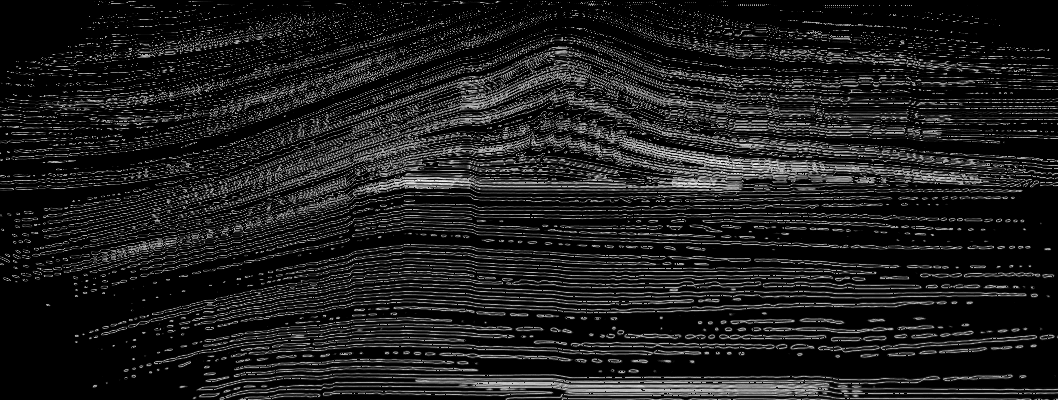

In [100]:
small_image

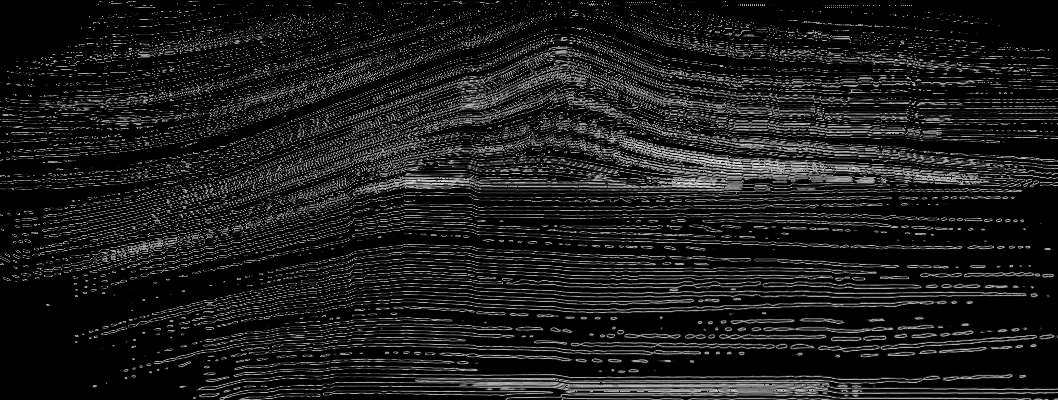

In [101]:
good_image

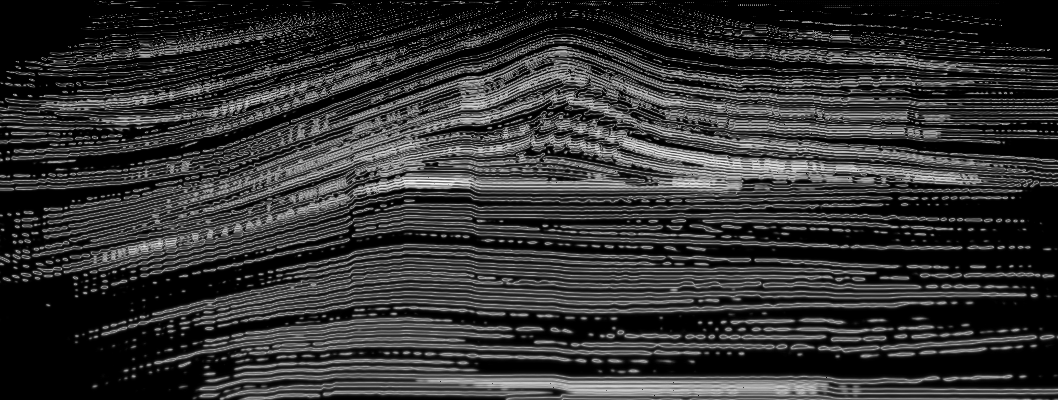

In [99]:
large_image

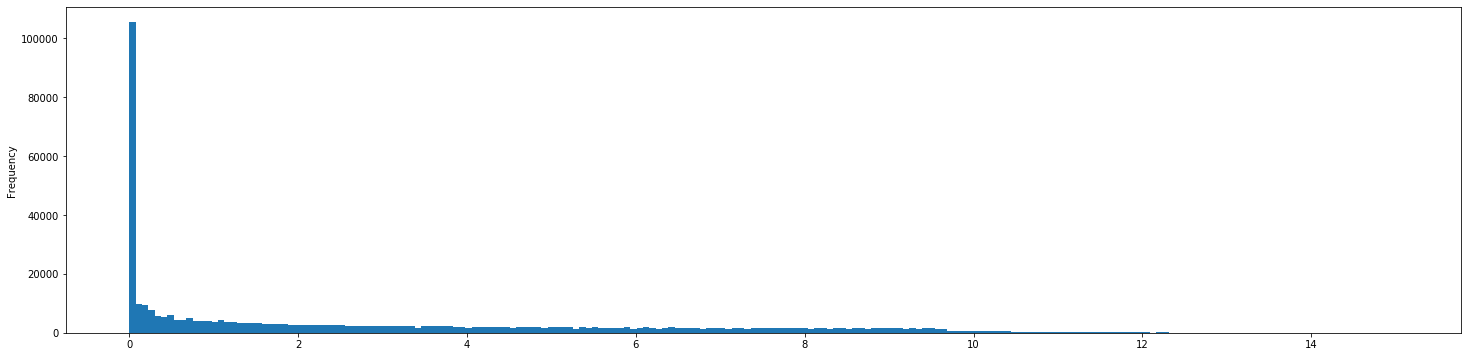

In [118]:
pd.Series(large_kl_arr.flatten()).plot(kind='hist', figsize=(25, 6), bins=200);

In [92]:
def crop_and_zoom(im, lo, hi, basewidth):
    cropped = im.crop((lo[0], lo[1], hi[0], hi[1]))
    wpercent = (basewidth/float(cropped.size[0]))
    hsize = int((float(cropped.size[1])*float(wpercent)))
    return cropped.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

def crop_zoom_concat(arr1, arr2, lo, hi, basewidth):
    cropped1 = arr1[lo[1]:hi[1], lo[0]:hi[0]]
    cropped2 = arr2[lo[1]:hi[1], lo[0]:hi[0]]
    # rescale the two cropped images
    min1 = cropped1.min()
    max1 = cropped1.max()
    cropped1 = (cropped1 - min1) / (max1 - min1)
    cropped1 = cropped1 * 255
    min2 = cropped2.min()
    max2 = cropped2.max()
    cropped2 = (cropped2 - min2) / (max2 - min2)
    cropped2 = cropped2 * 255
    stacked = np.hstack((cropped1, cropped2))
    print(stacked.shape)
    img = Image.fromarray(stacked)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    return img.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

In [2]:
crop_and_zoom(image, (400, 200), (450, 220), 1000)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_2.stack.segy'].transpose(), (400, 200), (450, 220), 1500)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_4.stack.segy'].transpose(), (500, 370), (550, 390), 1500)

NameError: name 'crop_and_zoom' is not defined

<h2 style="color:blue;"> Process gathers and find standard deviation summations for each realization </h2>

In [4]:
print(gather_dict['img_1.gather.segy'].shape)
from skimage import feature
# import itertools
# import random
# from sklearn.preprocessing import RobustScaler
# sub_arr = RobustScaler().fit_transform(sub_arr).reshape(sub_shape)


(1058, 39, 400)


<h2 style="color:blue;"> Process gathers using canny filter and determine the quality determined by horizontal lines </h2>

In [9]:
# collect all (transposed) sub arrays of 1058 gathers from image_10_gather.segy
    
def get_subarrs_gather(gather_dict):
    nrows = 1
    ncols = 1058

    gather_sub_arrs = defaultdict(list)
    sub_arrs = []

    for key in gather_dict:
        print(key)
        sub_arrs = []
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = gather_dict[key][c, :, :]
            sub_arr = sub_arr.transpose()
            sub_arrs.append(sub_arr)
        gather_sub_arrs[key] = sub_arrs
    return gather_sub_arrs

def get_subarrs_stack(stack_dict):
    nrows = 1
    ncols = 1058

    gather_sub_arrs = defaultdict(list)
    sub_arrs = []

    for key in stack_dict:
        print(key)
        sub_arrs = []
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = stack_dict[key][c]
            sub_arr = sub_arr.transpose()
            sub_arrs.append(sub_arr)
        gather_sub_arrs[key] = sub_arrs
    return gather_sub_arrs


large_subarrs = get_subarrs_stack(large_dict)

img_1.stack.segy
img_10.stack.segy
img_100.stack.segy
img_1000.stack.segy
img_101.stack.segy
img_102.stack.segy
img_103.stack.segy
img_104.stack.segy
img_105.stack.segy
img_106.stack.segy
img_107.stack.segy
img_108.stack.segy
img_109.stack.segy
img_11.stack.segy
img_110.stack.segy
img_111.stack.segy
img_112.stack.segy
img_113.stack.segy
img_114.stack.segy
img_115.stack.segy
img_116.stack.segy
img_117.stack.segy
img_118.stack.segy
img_119.stack.segy
img_12.stack.segy
img_120.stack.segy
img_121.stack.segy
img_122.stack.segy
img_123.stack.segy
img_124.stack.segy
img_125.stack.segy
img_126.stack.segy
img_127.stack.segy
img_128.stack.segy
img_129.stack.segy
img_13.stack.segy
img_130.stack.segy
img_131.stack.segy
img_132.stack.segy
img_133.stack.segy
img_134.stack.segy
img_135.stack.segy
img_136.stack.segy
img_137.stack.segy
img_138.stack.segy
img_139.stack.segy
img_14.stack.segy
img_140.stack.segy
img_141.stack.segy
img_142.stack.segy
img_143.stack.segy
img_144.stack.segy
img_145.stack.segy

In [19]:
len(large_subarrs['img_1.stack.segy'][0])

400

In [10]:
len(gather_sub_arrs['img_1.gather.segy'][0][0])

39

In [ ]:
# eliminate any rows of gathers that have values greater than 5 or less than -5

def clean_gathers_gather(gather_sub_arrs):
    max_val = 5
    min_val = -5
    clean_dict = defaultdict(list)
    for key in gather_sub_arrs:
        print(key)
        sub_arrs = gather_sub_arrs[key]
        new_sub_arrs = []

        c = 0
        for sub_arr in sub_arrs:
            truth_lst = []
            for arr in sub_arr:
                truth_lst.append(np.any(arr > 5) or np.any(arr < -5))
        #     print('number of Falses', truth_lst.count(False))
            idx = np.where(np.array(truth_lst) == False)
            new_sub_arrs.append(sub_arr[idx])
            c += 1
        clean_dict[key] = new_sub_arrs
    return clean_dict

def clean_gathers_stack(gather_sub_arrs):
    max_val = 5
    min_val = -5
    clean_dict = defaultdict(list)
    for key in gather_sub_arrs:
        print(key)
        sub_arrs = gather_sub_arrs[key]
        new_sub_arrs = []

        c = 0
        for sub_arr in sub_arrs:
            truth_lst = []
            for arr in sub_arr:
                truth_lst.append(np.any(arr > 5) or np.any(arr < -5))
        #     print('number of Falses', truth_lst.count(False))
            idx = np.where(np.array(truth_lst) == False)
            new_sub_arrs.append(sub_arr[idx])
            c += 1
        clean_dict[key] = new_sub_arrs
    return clean_dict


# clean_sub_arrs = clean_gathers_gather(gather_sub_arrs)
clean_stack_subarrs = clean_gathers_stack(large_subarrs)

img_1.stack.segy
img_10.stack.segy
img_100.stack.segy
img_1000.stack.segy
img_101.stack.segy
img_102.stack.segy
img_103.stack.segy
img_104.stack.segy
img_105.stack.segy
img_106.stack.segy
img_107.stack.segy
img_108.stack.segy
img_109.stack.segy
img_11.stack.segy
img_110.stack.segy
img_111.stack.segy
img_112.stack.segy
img_113.stack.segy
img_114.stack.segy
img_115.stack.segy
img_116.stack.segy
img_117.stack.segy
img_118.stack.segy
img_119.stack.segy
img_12.stack.segy
img_120.stack.segy
img_121.stack.segy
img_122.stack.segy
img_123.stack.segy
img_124.stack.segy
img_125.stack.segy
img_126.stack.segy
img_127.stack.segy
img_128.stack.segy
img_129.stack.segy
img_13.stack.segy
img_130.stack.segy
img_131.stack.segy
img_132.stack.segy
img_133.stack.segy
img_134.stack.segy
img_135.stack.segy
img_136.stack.segy
img_137.stack.segy
img_138.stack.segy
img_139.stack.segy
img_14.stack.segy
img_140.stack.segy
img_141.stack.segy
img_142.stack.segy
img_143.stack.segy
img_144.stack.segy
img_145.stack.segy

In [15]:
len(clean_sub_arrs['img_1.gather.segy'][0][0])

39

In [ ]:
# joblib.dump(clean_sub_arrs, 'clean_sub_arrs')
# clean_sub_arrs = joblib.load(open('clean_sub_arrs', 'rb'))

joblib.dump(clean_stack_subarrs, 'clean_stack_subarrs')
clean_stack_subarrs = joblib.load(open('clean_stack_subarrs', 'rb'))

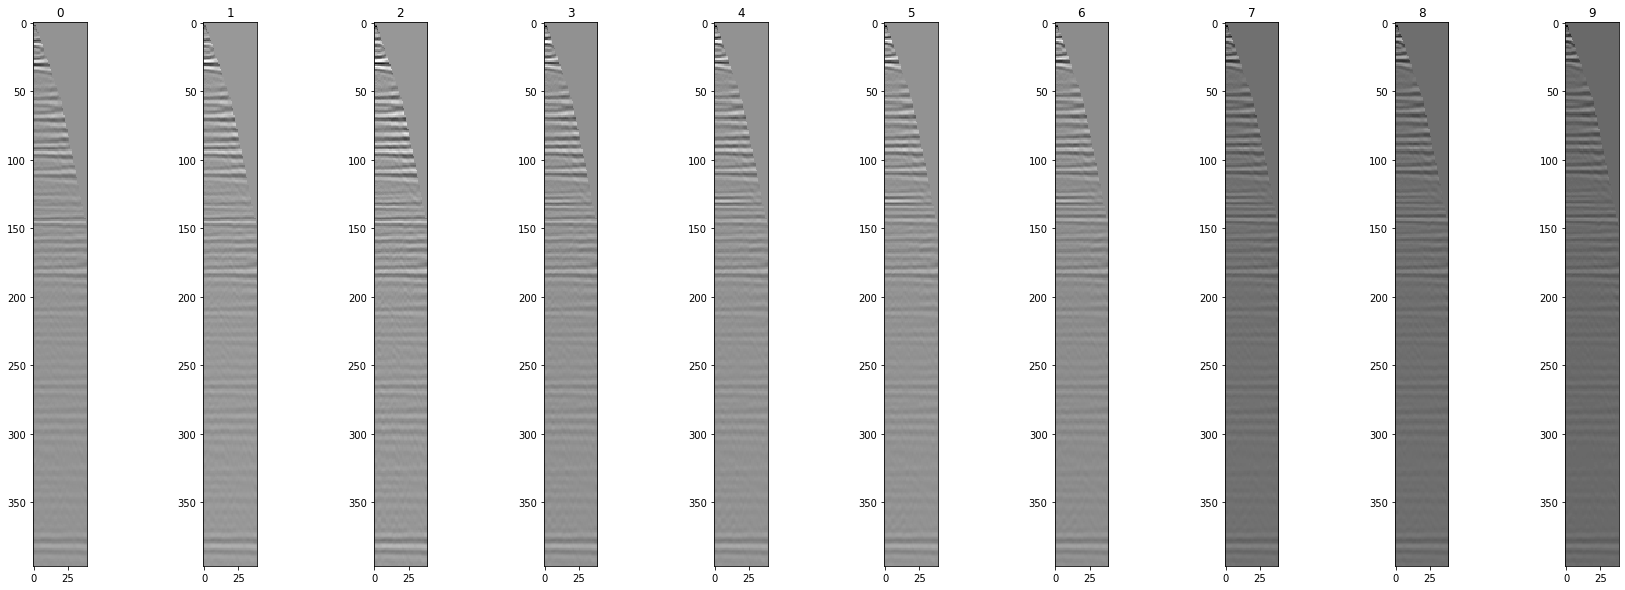

In [14]:
# plot new gathers after eliminating outlier rows (they are much easier to see without outlier pixels)
nrows = 1
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))

for c in range(500, 510):
    sub_arr = clean_sub_arrs[c]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[c-500].imshow(sub_arr, cmap = 'gray')

    title = str(c-500)
    axarr[c-500].set_title(title.strip())

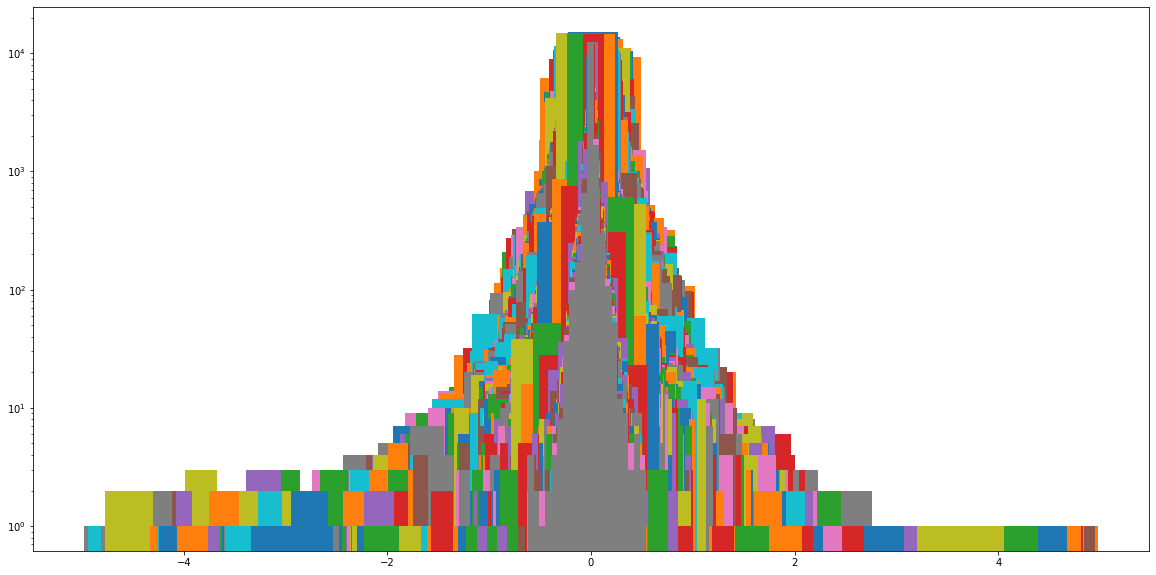

In [24]:
# to demonstrate how the rows are being eliminated from the gathers

plt.figure(figsize=(20, 10))
# for sub_arr in sub_arrs:
# #     print(min(sub_arr.flatten()), max(sub_arr.flatten()))
#     plt.hist(sub_arr.flatten(), bins=100, log=False);

# most values are centered around 0 and any value outside of -5 and 5 were eliminated 
for sub_arr in clean_sub_arrs:
    plt.hist(clean_sub_arrs[sub_arr].flatten(), bins=20, log=True);

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

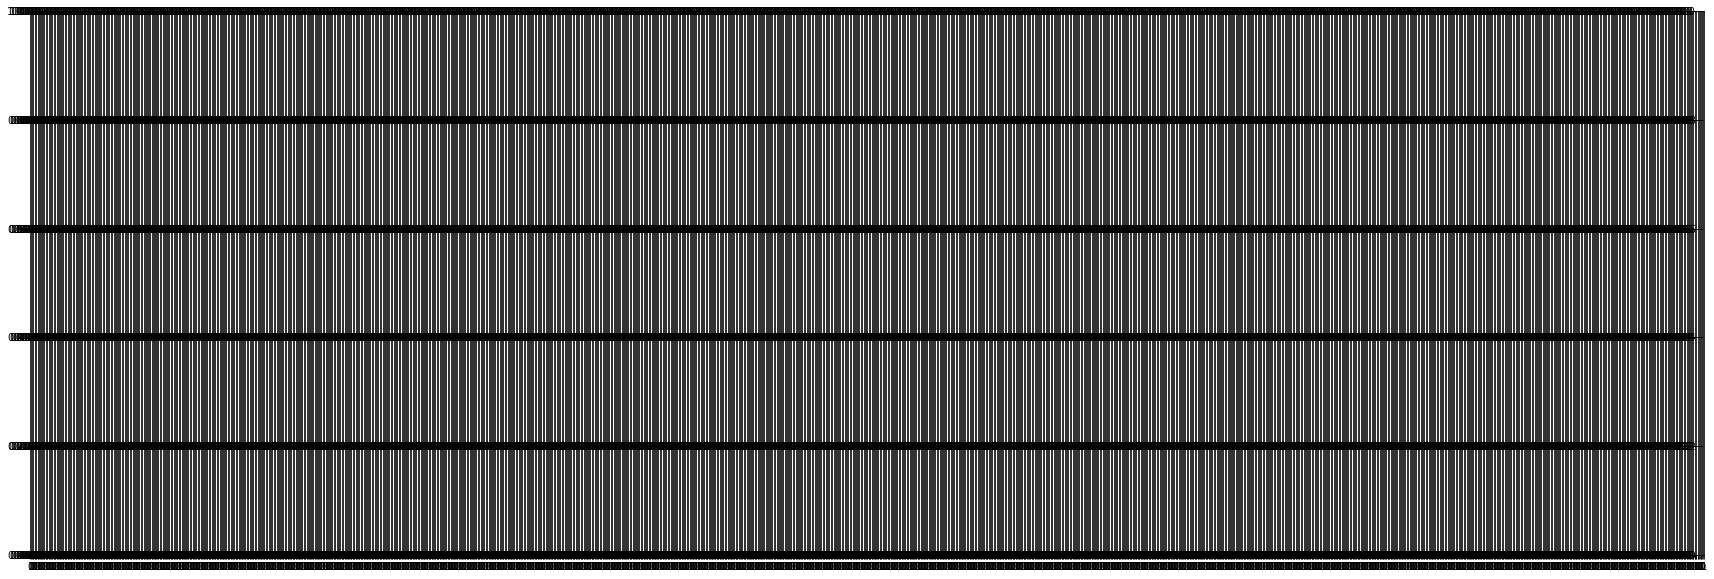

In [17]:
# apply canny filter to all the cleaned sub arrays to pick out optimal sigma

def get_canny_gather(gather_dict):
    ncols = 1058

    canny_dict = {}

    for key in gather_dict:
        print(key)
        edge_list = []
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = clean_sub_arrs[key][c]
            sub_shape = sub_arr.shape
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255

            edges = feature.canny(sub_arr, sigma=4)
            edge_list.append(edges)
        canny_dict[key] = edge_list
    return canny_dict

def get_canny_stack(stack_dict):
    ncols = 1058

    canny_dict = {}

    for key in stack_dict:
        print(key)
        edge_list = []
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = clean_stack_subarrs[key][c]
            sub_shape = sub_arr.shape
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255

            edges = feature.canny(sub_arr, sigma=4)
            edge_list.append(edges)
        canny_dict[key] = edge_list
    return canny_dict

In [19]:
joblib.dump(canny_dict, 'canny_dict')
canny_dict = joblib.load(open('canny_dict', 'rb'))

In [26]:
len(canny_dict['img_1.gather.segy'][0][0])

39

In [46]:
# length 1058 dictionaries, capturing information on all gathers' mode, mean, difference information among their rows
def canny_func(canny_dict):
    for key in canny_dict:
        print(key)
#         mode_dict = defaultdict(list)
#         mean_dict = defaultdict(list)
#         diff_dict = defaultdict(int)

        for c in range(1058):
            canny_dict[key][c] = canny_dict[key][c].astype(int)
#             for row in canny_dict[key][c]:
#                 mode_dict[c].append(mode(row)[0][0])
#                 mean_dict[c].append(np.mean(row))
#                 counter_dict = Counter(mode_dict[c])
#                 cnt_0, cnt_1 = counter_dict[0], counter_dict[1]
#                 diff_dict[c] = abs(cnt_0 - cnt_1)

#         canny_num_dict[key] = mode_dict, mean_dict, diff_dict
    return canny_dict

canny_num_dict = canny_func(canny_dict)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

In [59]:
# this implements Max's method of getting the distance between neighboring columns in a gather and summing them together to get a score for each gather
# low score: similar columns (better gather), high score: dissimilar columns (worse gather)
def dist_func(canny_num_dict):
    realization_scores = defaultdict(int)
    for key in canny_num_dict:
        print(key)
        gather_scores = defaultdict(dict)
        for c in range(1058):
            gather = np.transpose(canny_num_dict[key][c])
            dist_sum = 0
            for d in range(39):
                if d == 0:
                    score = np.linalg.norm(gather[d] - gather[d + 1])
                    dist_sum += score
                elif d == 38:
                    score = np.linalg.norm(gather[d] - gather[d - 1])
                    dist_sum += score
                else:
                    score = np.linalg.norm(gather[d] - gather[d - 1]) + np.linalg.norm(gather[d] - gather[d + 1])
                    dist_sum += score
            gather_scores[key][c] = dist_sum
        gather_sum = sum(gather_scores[key].values())
        realization_scores[key] = gather_sum
    return realization_scores

realization_scores = dist_func(canny_num_dict)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

(array([ 3.,  7.,  3.,  6.,  6., 13., 10.,  5.,  4.,  1.]),
 array([283471.3205656 , 283935.74630941, 284400.17205322, 284864.59779703,
        285329.02354084, 285793.44928466, 286257.87502847, 286722.30077228,
        287186.72651609, 287651.1522599 , 288115.57800372]),
 <a list of 10 Patch objects>)

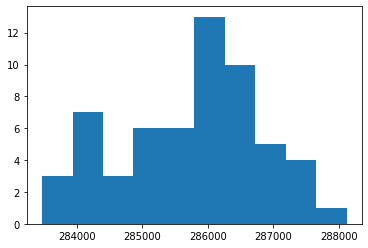

In [71]:
plt.hist(realization_scores.values())

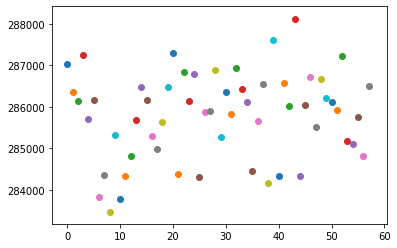

In [70]:
for counter, value in enumerate(realization_scores.values()):
    plt.scatter(counter, value)

In [72]:
good_realizations = []
for key in realization_scores:
    if realization_scores[key] < 286000:
        good_realizations.append(key)

In [73]:
good_realizations

['img_13.gather.segy',
 'img_15.gather.segy',
 'img_16.gather.segy',
 'img_17.gather.segy',
 'img_18.gather.segy',
 'img_19.gather.segy',
 'img_2.gather.segy',
 'img_20.gather.segy',
 'img_21.gather.segy',
 'img_24.gather.segy',
 'img_25.gather.segy',
 'img_26.gather.segy',
 'img_29.gather.segy',
 'img_32.gather.segy',
 'img_33.gather.segy',
 'img_34.gather.segy',
 'img_36.gather.segy',
 'img_38.gather.segy',
 'img_41.gather.segy',
 'img_42.gather.segy',
 'img_44.gather.segy',
 'img_46.gather.segy',
 'img_5.gather.segy',
 'img_52.gather.segy',
 'img_56.gather.segy',
 'img_58.gather.segy',
 'img_59.gather.segy',
 'img_6.gather.segy',
 'img_7.gather.segy']

In [71]:
# get the indices of the 
def gather_indices(dist_dict):
    dist_lst = sorted(dist_dict.items(), key=lambda x: x[1])
    low_scores_idx = [x[0] for x in dist_lst[0:10]]
    high_scores_idx = [x[0] for x in dist_lst[-11:-1]]
    return low_scores_idx, high_scores_idx

low_scores_idx, high_scores_idx = gather_indices(dist_dict)

([998, 101, 1000, 350, 100, 349, 1002, 123, 128, 353],
 [10, 34, 41, 80, 2, 43, 42, 75, 40, 37])

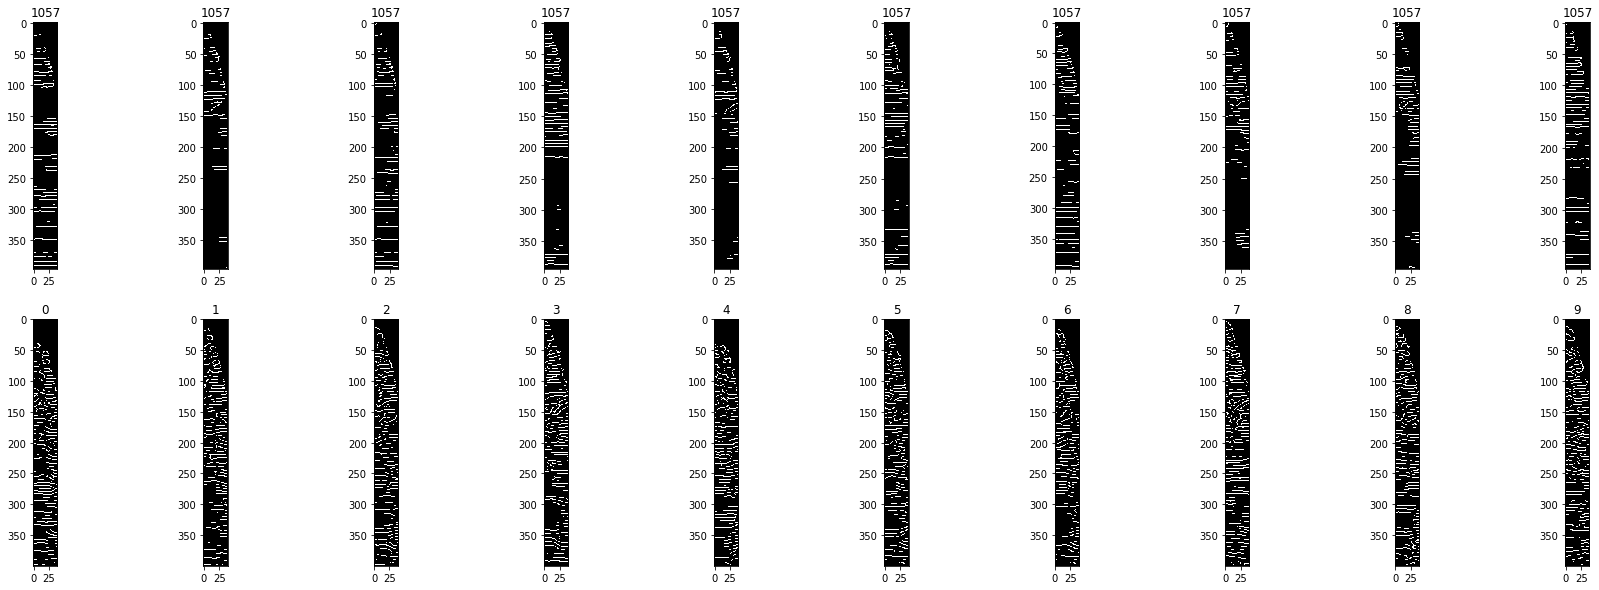

In [81]:
# among the 10 best and 10 worst gathers, check out their canny images
nrows = 2
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))

# for c in range(ncols):
canny_img = [canny_lst[i] for i in low_scores_idx]
for i in range(10):
    axarr[0, i].imshow(canny_img[i], cmap = 'gray')
    title = str(c)
    axarr[0, i].set_title(title.strip())

canny_img = [canny_lst[i] for i in high_scores_idx]
for i in range(10):
    axarr[1, i].imshow(canny_img[i], cmap = 'gray')
    title = str(i)
    axarr[1, i].set_title(title.strip())

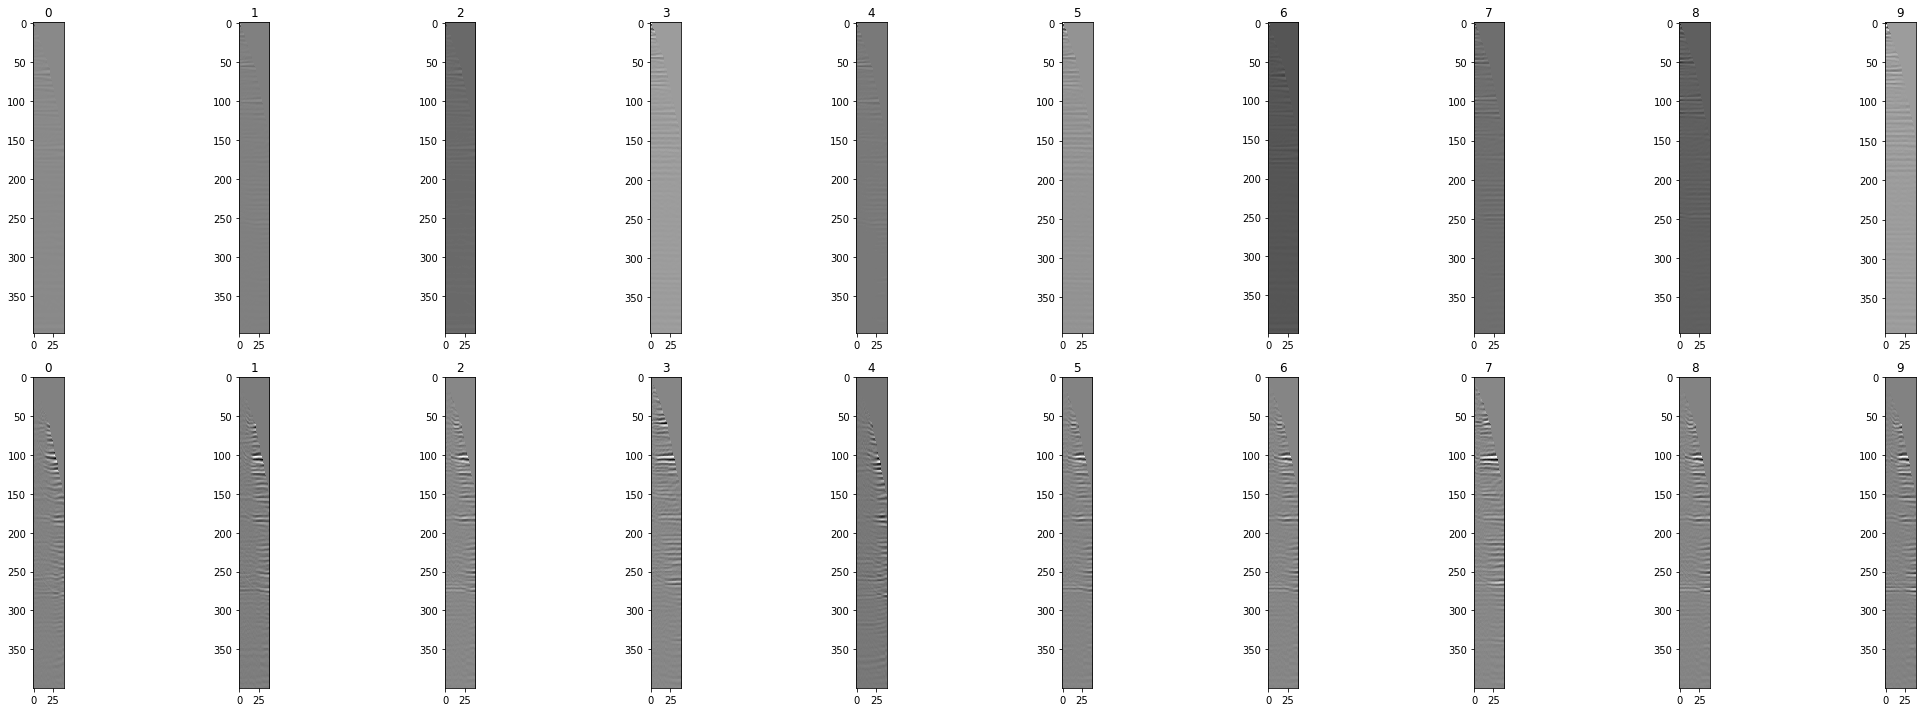

In [80]:
# plot original gather images of the top 10 worst and best gathers
nrows = 2
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))

canny_img = [clean_sub_arrs[i] for i in low_scores_idx]

for i in range(10):
    sub_arr = canny_img[i]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[0, i].imshow(canny_img[i], cmap = 'gray')
    title = str(i)
    axarr[0, i].set_title(title.strip())

canny_img = [clean_sub_arrs[i] for i in high_scores_idx]

for i in range(10):
    sub_arr = canny_img[i]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[1, i].imshow(canny_img[i], cmap = 'gray')
    title = str(i)
    axarr[1, i].set_title(title.strip())
    
plt.tight_layout()

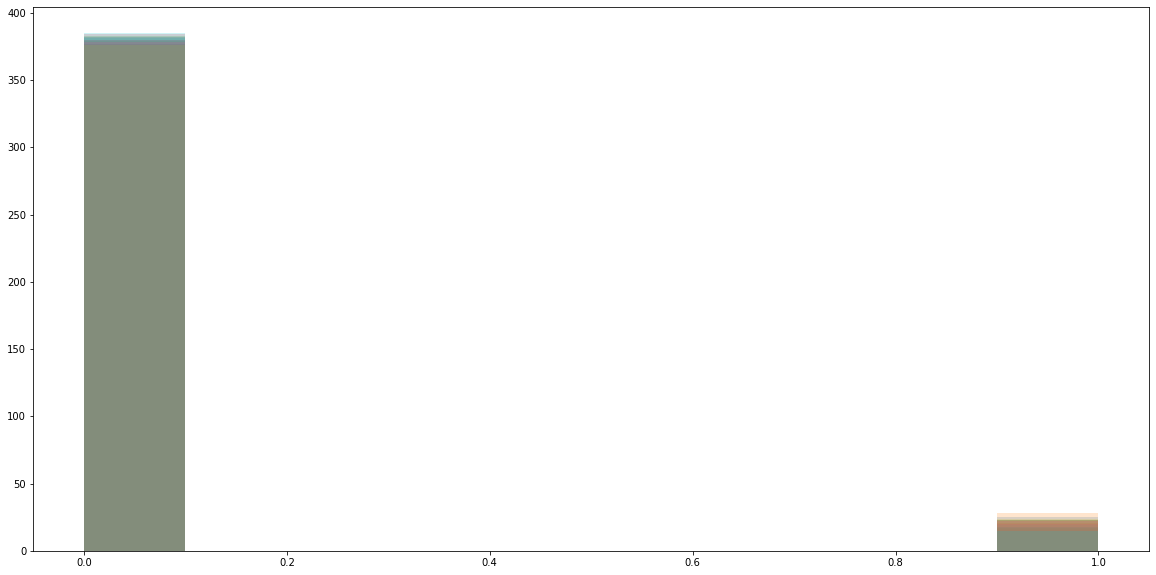

In [35]:
plt.figure(figsize=(20, 10))
for key in mode_dict:
    plt.hist(mode_dict[key], alpha=0.2);
# for key in mean_dict:
#     plt.hist(mean_dict[key], alpha=0.2);
# for key in diff_dict:
#     plt.hist(diff_dict[key], alpha=0.2);

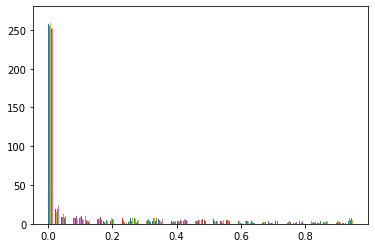

In [22]:
plt.hist(mean_dict.values(), bins=50);
# len(diff_dict.values())

In [29]:
# this code was necessary to round pre-scaled pixels to the nearest 0.0/1.0 value
round_dict = defaultdict(int)
for c in range(ncols):
    # Pull out all offset pairs for a given x
    gather = dup_vals[c]
    rounded = []
    for row in gather:
        rounded.append([0.0 if x <= 0.5 else 1.0 for x in row])
    round_dict[c] = np.array(rounded)

# this dictionary finds the mode (0/1) per row for a gather 
mode_dict = defaultdict(list)
for c in range(ncols):
    gather = round_dict[c]
    for row in gather:
        mode_val, _ = mode(row)
        mode_dict[c].append(mode_val[0])

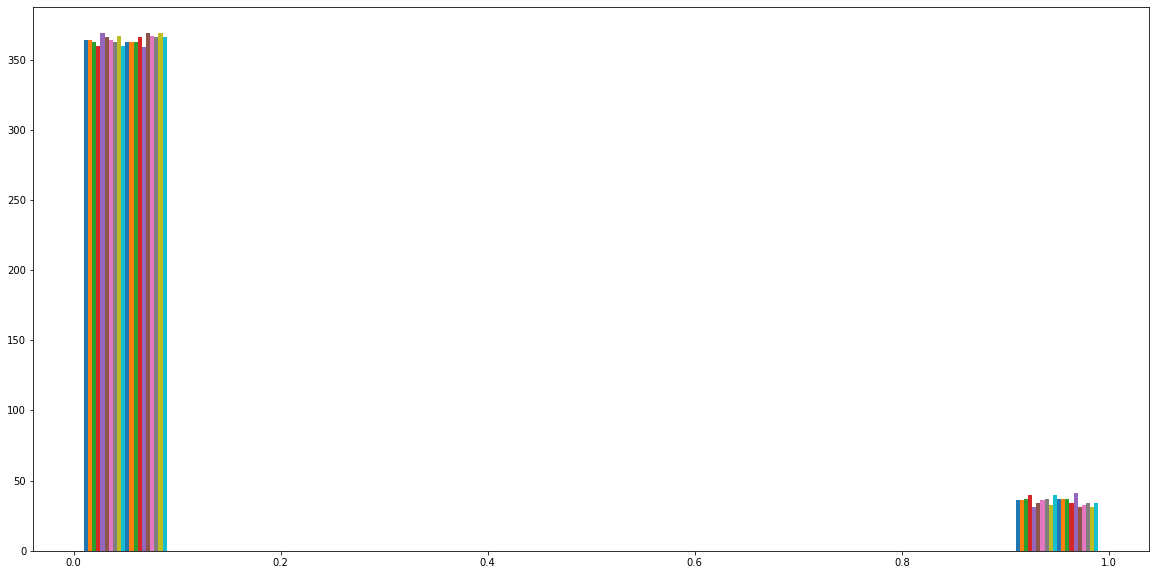

In [21]:
# this plots the histogram distribution of all 1058 gathers for a given file
values = mode_dict.values()
plt.figure(figsize=(20, 10))
plt.hist(values);

In [ ]:
# computes horizontal derivative (vertical edges)
sub_arr_x = ndimage.sobel(sub_arr, 0)
axarr[c].imshow(sub_arr_x, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_y = ndimage.sobel(sub_arr, 1)
axarr[c+1].imshow(sub_arr_y, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_lap = ndimage.laplace(sub_arr)
axarr[c+2].imshow(sub_arr_lap, cmap = 'gray') 

In [6]:
def gather_std(gather_dict, ncols=1058):
    std_dict = defaultdict(list)

    std_sums = defaultdict(list)
    for key in gather_dict.keys():
        arr = gather_dict[key]
        std_sum = 0
        
        # for each of the 1058 ncol GATHERs
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = arr[c, :, :]
            sub_arr = sub_arr.transpose()
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255
            
            std_val = np.std(sub_arr, axis=0).sum()
            std_dict[key].append(std_val)
        
    return std_dict

std_dict = gather_std(gather_dict)

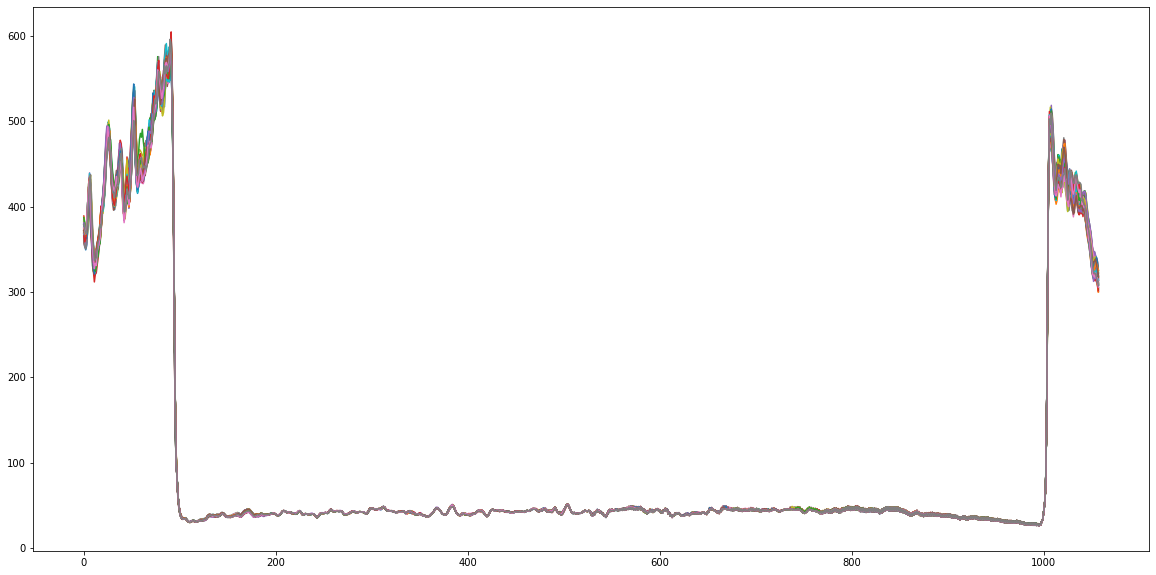

In [10]:
# this plots the std deviation distribution of the rows of all 1058 gathers
plt.figure(figsize=(20, 10))
for key in std_dict:
    plt.plot(std_dict[key])

In [13]:
min_std = std_dict['img_1.gather.segy'].index(min(std_dict['img_1.gather.segy']))
max_std = std_dict['img_1.gather.segy'].index(max(std_dict['img_1.gather.segy']))
std_list = [min_std, max_std]

# sort by lowest to highest std among gathers for one image
sort_std = sorted(std_dict['img_1.gather.segy'])
min5_std = sort_std[0:10]
max5_std = sort_std[-11:-1]

# get their indices
min_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in min5_std]
max_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in max5_std]

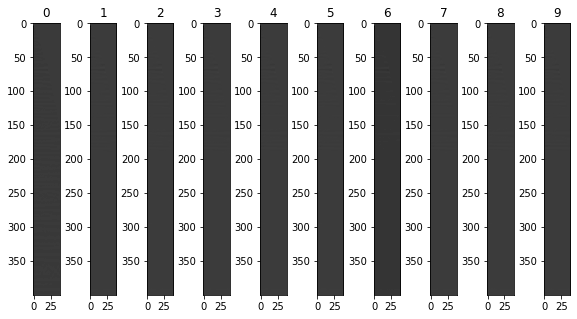

In [17]:
# top 10 gathers with lowest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in min_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1

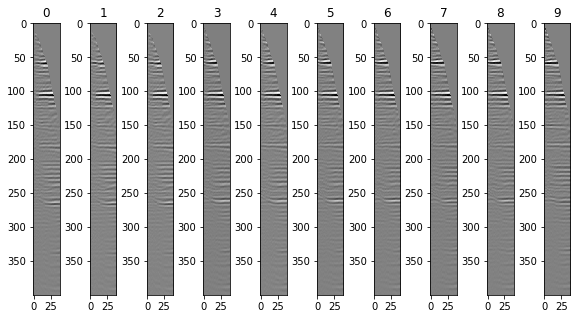

In [18]:
# top 10 gathers with highest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in max_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1